# Emotions Detection with Transfer Learning

## dependencies

In [46]:
import os
import random
import imghdr
from PIL import Image
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard, CSVLogger
from keras.utils import plot_model

## datasets; FER2013

In [2]:
# kaggle api configuration
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
# downloading the fer2013 dataset
!kaggle datasets download -d msambare/fer2013

Dataset URL: https://www.kaggle.com/datasets/msambare/fer2013
License(s): DbCL-1.0
  0% 0.00/60.3M [00:00<?, ?B/s]
100% 60.3M/60.3M [00:00<00:00, 1.74GB/s]


In [4]:
!ls

fer2013.zip  kaggle.json  sample_data


In [ ]:
# unzipping the dataset
!unzip /content/fer2013.zip -d /content/

In [6]:
!ls

fer2013.zip  kaggle.json  sample_data  test  train


## model data directories

In [7]:
# project name
project_name = "Emotion_Detection_FER2013"

# models list
model_names = [
    'Custom_CNN_From_Scratch',
    'Custom_CNN_With_Augmentation',
    'VGG16_Transfer_Learning',
    'ResNet50_Transfer_Learning'
]

# base directory
base_dir = "/content/"

In [8]:
# creating project directory
project_dir = os.path.join(base_dir, project_name)
os.makedirs(project_dir, exist_ok=True)

In [9]:
# creating model's sub-directories
for model_name in model_names:
  model_dir = os.path.join(project_dir, model_name)
  os.makedirs(model_dir, exist_ok=True)

## data cleaning

In [10]:
# possible image extensions
exts = ["jpg", "jpeg", "png"]
data_dir = "/content/train"

In [11]:
for root, dirs, files in os.walk(data_dir):
  for file in files:
    file_path = os.path.join(root, file)

    try:
      # file type of the currrent type
      file_type = imghdr.what(file_path)
      if file_type not in exts:
        print(f"Image not in extensions list {file_path}")
        os.remove(file_path)
      else:
        img = cv2.imread(file_path)

    except Exception as e:
      print(f"issue with file {file_path}. error: {e}")

## exploratory data analysis

In [12]:
# file counter function
def count_subdirs_files(directory, set_name):
  counts = {}
  for item in os.listdir(directory):
    item_path = os.path.join(directory, item)
    if os.path.isdir(item_path):
      counts[item] = len(os.listdir(item_path))

  data = pd.DataFrame(counts, index=[set_name])
  return data

In [13]:
# train test directory
train_dir = "/content/train"
test_dir = "/content/test"

In [14]:
# train count
train_count = count_subdirs_files(train_dir, "train")
print(train_count)

        sad  fear  surprise  happy  neutral  angry  disgust
train  4830  4097      3171   7215     4965   3995      436


In [15]:
# test count
test_count = count_subdirs_files(test_dir, "test")
print(test_count)

       sad  fear  surprise  happy  neutral  angry  disgust
test  1247  1024       831   1774     1233    958      111


<Axes: >

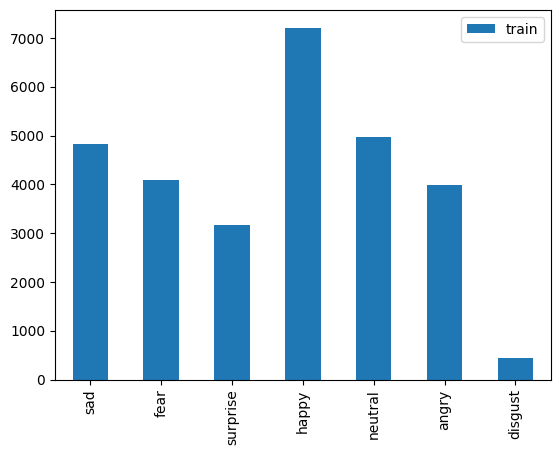

In [16]:
# simple train barplot
train_count.transpose().plot(kind="bar")

<Axes: >

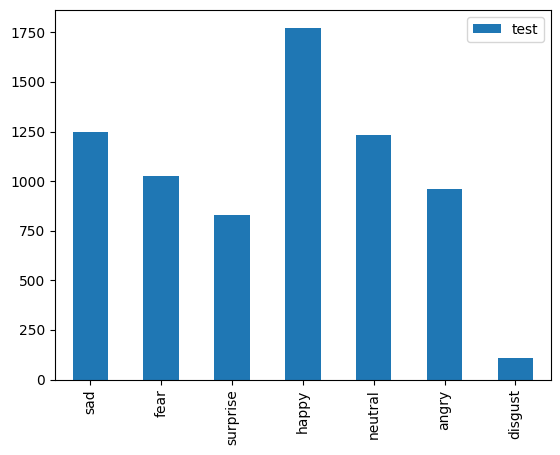

In [17]:
test_count.transpose().plot(kind="bar")

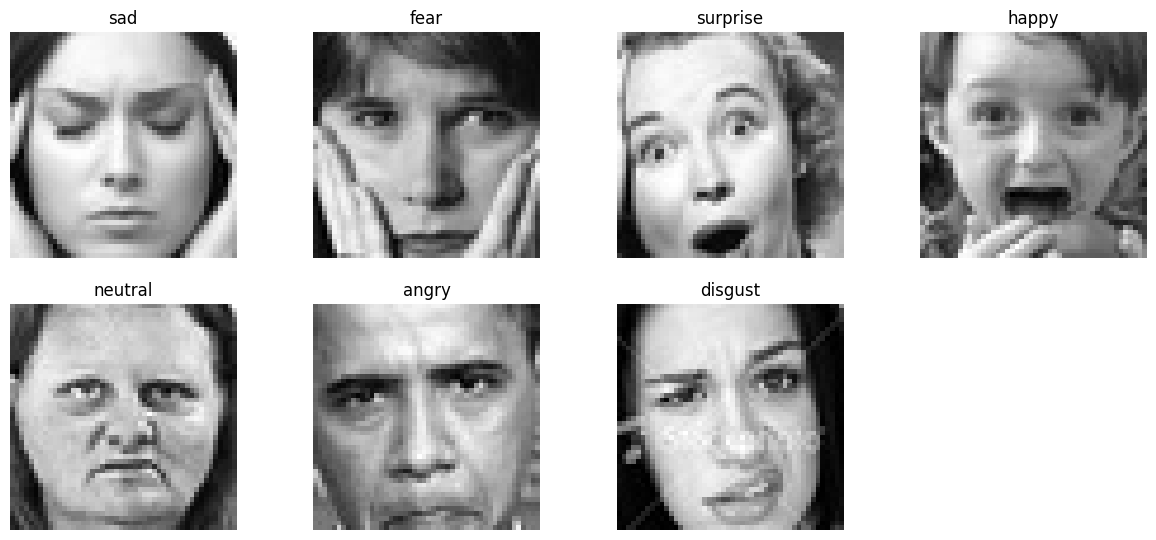

In [18]:
# plotting one image from each emotion
emotions = os.listdir(train_dir)
plt.figure(figsize=(15, 10))

for idx, emotion in enumerate(emotions, 1):
  folder = os.path.join(train_dir, emotion)
  img_path = os.path.join(folder, os.listdir(folder)[42])
  img = plt.imread(img_path)
  plt.subplot(3, 4, idx)
  plt.imshow(img, cmap="gray")
  plt.title(emotion)
  plt.axis("off")

## plotting random images from the given directory

In [19]:
def plot_from_dir(dir_path, cls_name, num_imgs=9):
  img_names = os.listdir(dir_path)
  if len(img_names) < num_imgs:
    print(f"only found {len(img_names)} images in {dir_path}. displaying them all")
    num_imgs = img_names

  # selecting random images
  imgs_select = random.sample(img_names, num_imgs)

  # plotting the images
  fig, ax = plt.subplots(3, 3, figsize=(6, 6))
  ax = ax.ravel()

  for idx, img, in enumerate(imgs_select):
    img_path = os.path.join(dir_path, img)
    image = Image.open(img_path)
    ax[idx].imshow(image)
    ax[idx].set_title(f"image: {cls_name}")
    ax[idx].axis("off")

  plt.tight_layout()
  plt.show()

In [20]:
# sample emotions paths
angry_path = "/content/train/angry"
fear_path = "/content/train/fear"
neutral_path = "/content/train/neutral"
sad_path = "/content/train/sad"

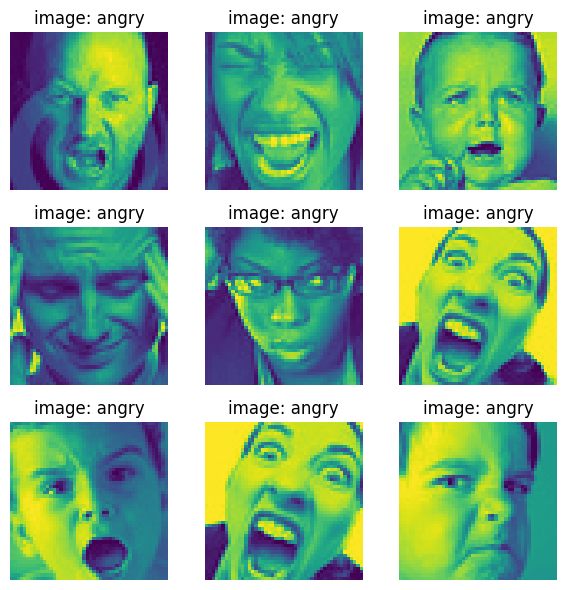

In [21]:
# plotting angry
plot_from_dir(angry_path, cls_name="angry")

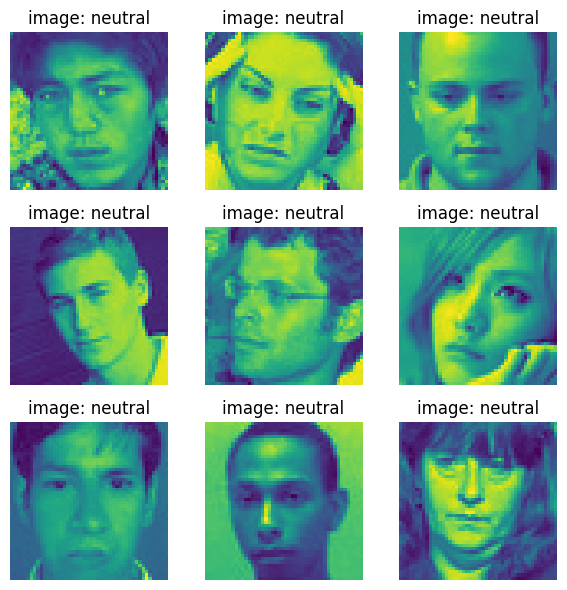

In [22]:
# plotting neutral
plot_from_dir(neutral_path, cls_name="neutral")

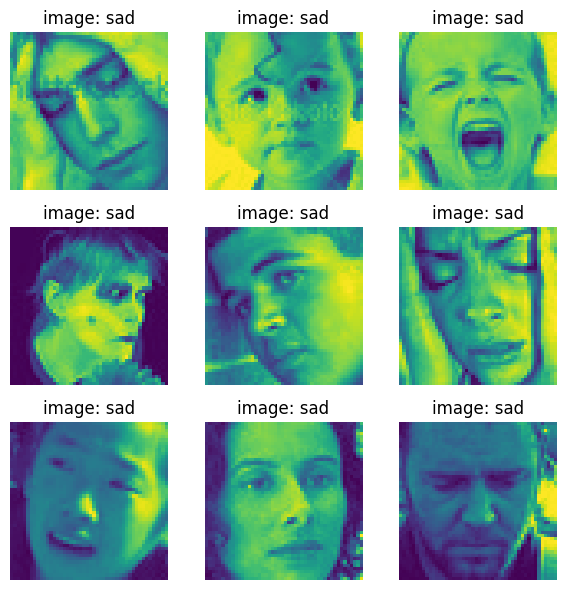

In [23]:
# plotting sad
plot_from_dir(sad_path, cls_name="sad")

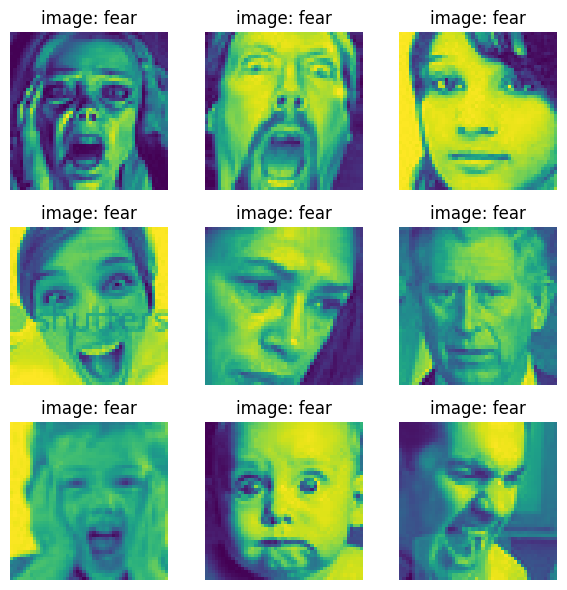

In [24]:
# plotting fear
plot_from_dir(fear_path, cls_name="fear")

In [25]:
# checking shapes and channels
def img_shapes_channels(image_dir, samples=5):
  images = os.listdir(image_dir)
  img_samples = random.sample(images, samples)

  for img_name in img_samples:
    img_path = os.path.join(image_dir, img_name)
    image = cv2.imread(img_path)

    if image is not None:
      print(f"{img_name} -> shape: {image.shape}")
    else:
      print(f"{img_name} could not be loaded (not an image or bad path)")

In [26]:
img_shapes_channels(angry_path)

Training_76749650.jpg -> shape: (48, 48, 3)
Training_36718389.jpg -> shape: (48, 48, 3)
Training_84273122.jpg -> shape: (48, 48, 3)
Training_49535440.jpg -> shape: (48, 48, 3)
Training_7865887.jpg -> shape: (48, 48, 3)


In [27]:
img_shapes_channels(sad_path)

Training_15719621.jpg -> shape: (48, 48, 3)
Training_85292865.jpg -> shape: (48, 48, 3)
Training_94255939.jpg -> shape: (48, 48, 3)
Training_29556458.jpg -> shape: (48, 48, 3)
Training_21293937.jpg -> shape: (48, 48, 3)


In [28]:
img_shapes_channels(neutral_path)

Training_79459125.jpg -> shape: (48, 48, 3)
Training_62669781.jpg -> shape: (48, 48, 3)
Training_19816711.jpg -> shape: (48, 48, 3)
Training_39817403.jpg -> shape: (48, 48, 3)
Training_41762390.jpg -> shape: (48, 48, 3)


In [29]:
img_shapes_channels(fear_path)

Training_71253631.jpg -> shape: (48, 48, 3)
Training_71904248.jpg -> shape: (48, 48, 3)
Training_52868666.jpg -> shape: (48, 48, 3)
Training_88673713.jpg -> shape: (48, 48, 3)
Training_76434625.jpg -> shape: (48, 48, 3)


## retrieving imges & their classes to generate data from directories

In [30]:
train_dir = "/content/train"
test_dir = "/content/test"
IMG_SIZE = 48
BATCH_SIZE = 32
EPOCHS = 10
num_classes = 7

In [31]:
# scaling
data_generator = ImageDataGenerator(
    rescale = 1./255,
    validation_split = 0.2
)

In [32]:
train_generator = data_generator.flow_from_directory(
    train_dir,
    target_size =  (IMG_SIZE, IMG_SIZE),
    batch_size = BATCH_SIZE,
    class_mode = "categorical",
    color_mode = "grayscale",
    subset = "training"
)

Found 22968 images belonging to 7 classes.


In [33]:
val_generator = data_generator.flow_from_directory(
    train_dir,
    target_size =  (IMG_SIZE, IMG_SIZE),
    batch_size = BATCH_SIZE,
    class_mode = "categorical",
    color_mode = "grayscale",
    subset = "validation"
)

Found 5741 images belonging to 7 classes.


In [34]:
test_generator = data_generator.flow_from_directory(
    test_dir,
    target_size =  (IMG_SIZE, IMG_SIZE),
    batch_size = BATCH_SIZE,
    class_mode = "categorical",
    color_mode = "grayscale",
)

Found 7178 images belonging to 7 classes.


In [35]:
# train class labels
train_class_labels = train_generator.class_indices
print("training class labels:", train_class_labels)

training class labels: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


In [36]:
# val class labels
val_class_labels = val_generator.class_indices
print("validation class labels:", val_class_labels)

validation class labels: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


In [37]:
# test class labels
test_class_labels = test_generator.class_indices
print("test class labels:", test_class_labels)

test class labels: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


## Model 1: Custom CNN from Scratch

In [38]:
model = tf.keras.Sequential([
    # input
    tf.keras.layers.Input(shape=(IMG_SIZE, IMG_SIZE, 1)),

    # block 1
    tf.keras.layers.Conv2D(
        32,
        kernel_size=(3, 3),
        padding="same",
        kernel_initializer="glorot_uniform",
        activation="relu"
    ),

    tf.keras.layers.Conv2D(
        64,
        kernel_size=(3, 3),
        padding="same",
        activation="relu"
    ),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.25),

    # block 2
    tf.keras.layers.Conv2D(
        128,
        kernel_size=(3, 3),
        padding="same",
        kernel_regularizer=tf.keras.regularizers.l2(0.01),
        activation="relu"
    ),

    tf.keras.layers.Conv2D(
        256,
        kernel_size=(3, 3),
        kernel_regularizer=tf.keras.regularizers.l2(0.01),
        activation="relu"
    ),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.25),

    # block 3
    tf.keras.layers.Conv2D(
        512,
        kernel_size=(3, 3),
        padding="same",
        kernel_regularizer=tf.keras.regularizers.l2(0.01),
        activation="relu"
    ),

    tf.keras.layers.Conv2D(
        512,
        kernel_size=(3, 3),
        padding="same",
        kernel_regularizer=tf.keras.regularizers.l2(0.01),
        activation="relu"
    ),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.25),

    # classifier
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024, activation="relu"),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Dense(num_classes, activation="softmax")
])

In [39]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 22, 22, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 22, 22, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 11, 11, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 11, 11, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 11, 11, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 11, 11, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 11, 11, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 5, 5, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 5, 5, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │    13,108,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │         7,175 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,046,535 (65.03 MB)

 Trainable params: 17,044,871 (65.02 MB)

 Non-trainable params: 1,664 (6.50 KB)

In [41]:
# compiling the model
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
model.compile(
    optimizer = optimizer,
    loss = "categorical_crossentropy",
    metrics = ["accuracy"]
)

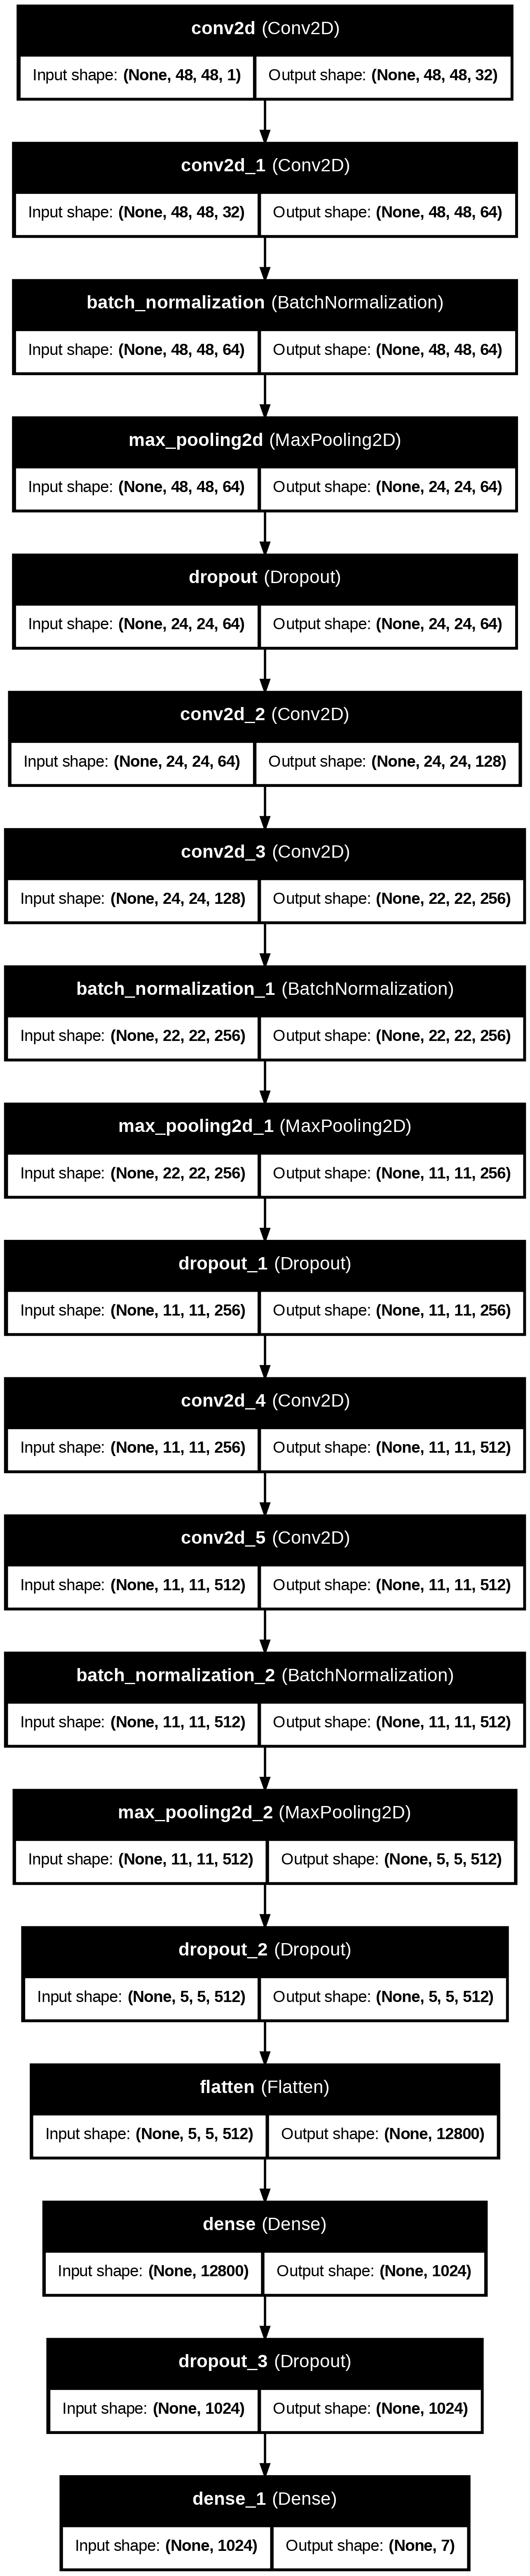

In [43]:
# plotting the model
plot_model(
    model,
    to_file = "/content/Emotion_Detection_FER2013/Custom_CNN_From_Scratch/Architecture.png",
    show_shapes = True,
    show_layer_names = True
)

In [45]:
# checkpoint path
cnn_path = "/content/Emotion_Detection_FER2013/Custom_CNN_From_Scratch"
name = "Custom_CNN_model.keras"
chk_path = os.path.join(cnn_path, name)
chk_path

'/content/Emotion_Detection_FER2013/Custom_CNN_From_Scratch/Custom_CNN_model.keras'

In [48]:
# model save checkpoint callback
checkpoint = ModelCheckpoint(
    filepath = chk_path,
    save_best_only = True,
    verbose = 1,
    mode = "min",
    monitor = "val_loss"
)

In [49]:
# earlystopping checkpoint
earlystop = EarlyStopping(
    monitor = "val_loss",
    min_delta = 0,
    patience = 3,
    verbose = 1,
    restore_best_weights = True
)

In [51]:

# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(
    monitor = 'val_loss',
    factor = 0.2,
    patience = 6,
    verbose = 1,
    min_delta = 1e-4
)

In [52]:
# callback to log training data to a csv file
csv_logger = CSVLogger(
    os.path.join(cnn_path, "training.log")
)

In [53]:
# callback list
callbacks = [
    checkpoint,
    earlystop,
    reduce_lr,
    csv_logger
]

In [54]:
train_generator.samples

22968

In [55]:

# calculating steps for each epoch
train_steps_per_epoch = train_generator.samples // train_generator.batch_size + 1
val_steps_epoch = val_generator.samples // val_generator.batch_size + 1
test_steps_epoch = test_generator.samples // test_generator.batch_size + 1

In [ ]:
# training
history = model.fit(
    train_generator,
    steps_per_epoch = train_steps_per_epoch,
    epochs = 10,
    validation_data = val_generator,
    validation_steps = val_steps_epoch,
    callbacks = callbacks
)